In [1]:
%load_ext cudf.pandas
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap  


In [2]:
%load_ext cuml.accel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

cuML: Installed accelerator for sklearn.
cuML: Installed accelerator for umap.
cuML: Successfully initialized accelerator.


In [4]:
%%time
#read in the datasets
embeddings_df = pd.read_parquet('embeddings2025/embeddings.parquet')
captions_df   = pd.read_parquet('embeddings2025/captions.parquet')

#took 6.9s dataset is 2.68G

CPU times: user 2.31 s, sys: 1.16 s, total: 3.47 s
Wall time: 1.59 s


In [5]:
# grab the embedding data 
X_embeddings=embeddings_df.values

# check size of embeddings
print(X_embeddings.shape)
# what's the data type?
print(X_embeddings.dtype)

(652671, 768)
float32


In [6]:
%%time

## KMeans on all the data
# 1. Instantiate the model
kmeans = KMeans(n_clusters=10, random_state=0, n_init='auto')

# 2. Fit and predict cluster labels
kmeans_labels = kmeans.fit_predict(X_embeddings)  

# 3. Inspect results
kmeans_centroids = kmeans.cluster_centers_
print("Labels:", kmeans_labels)

# 10  clusters took 48.7s on Brev: data is (652671 x 768d)
# 300 clusters took 21minutes 9s on Brev. same data

Labels: [8 1 4 ... 2 3 0]
CPU times: user 1.07 s, sys: 89.2 ms, total: 1.16 s
Wall time: 1.16 s


In [22]:
%%time

## KMeans on all the data
# 1. Instantiate the model
kmeans = KMeans(n_clusters=300, random_state=0, n_init='auto')

# 2. Fit and predict cluster labels
kmeans_labels = kmeans.fit_predict(X_embeddings)  

# 3. Inspect results
kmeans_centroids = kmeans.cluster_centers_
print("Labels:", kmeans_labels)

# 10  clusters took 48.7s on Brev: data is (652671 x 768d)


Labels: [240 155 287 ...  77  86  90]
CPU times: user 11.3 s, sys: 119 ms, total: 11.4 s
Wall time: 11.3 s


In [7]:
%%time
## PCA
# 1a. If X is a pandas DataFrame, convert to NumPy
X_np = X_embeddings.values if hasattr(X_embeddings, "values") else X_embeddings

# 1b. PCA to 50 components
pca = PCA(n_components=10, random_state=42)
X_reduced = pca.fit_transform(X_np)


Unused keyword parameter: random_state during cuML estimator initialization
CPU times: user 380 ms, sys: 331 ms, total: 711 ms
Wall time: 829 ms


In [8]:
%%time

import umap  

manifold = umap.UMAP(n_neighbors=30,min_dist=0.5).fit(X_reduced)
X_reduced_umap = manifold.transform(X_reduced)

Building knn graph using nn descent
Transform can only be run with brute force. Using brute force.
CPU times: user 1min 14s, sys: 1.59 s, total: 1min 16s
Wall time: 28.6 s


In [17]:
%%time

from sklearn.manifold import TSNE

# 1. Instantiate sklearn t-SNE
tsne = TSNE(
    n_components=2,          # target dimensionality
    perplexity=30,           # neighbors considered in high-D space (5-50) default 30
    learning_rate=200,       # typical: 10–1000 default 200
    n_iter=1000,             # optimization steps
    method='barnes_hut',     # fast approximation algorithm
    random_state=42,         # for reproducible results
    verbose=1                # show progress
)

# 2. Fit and transform with sklearn (CPU-based)
X_tsne_sklearn = tsne.fit_transform(X_reduced)  # returns a NumPy array

# 2m 4s on 300d ->2d
# 44.5s on 10s->2d

CPU times: user 38.7 s, sys: 5.96 s, total: 44.7 s
Wall time: 44.5 s


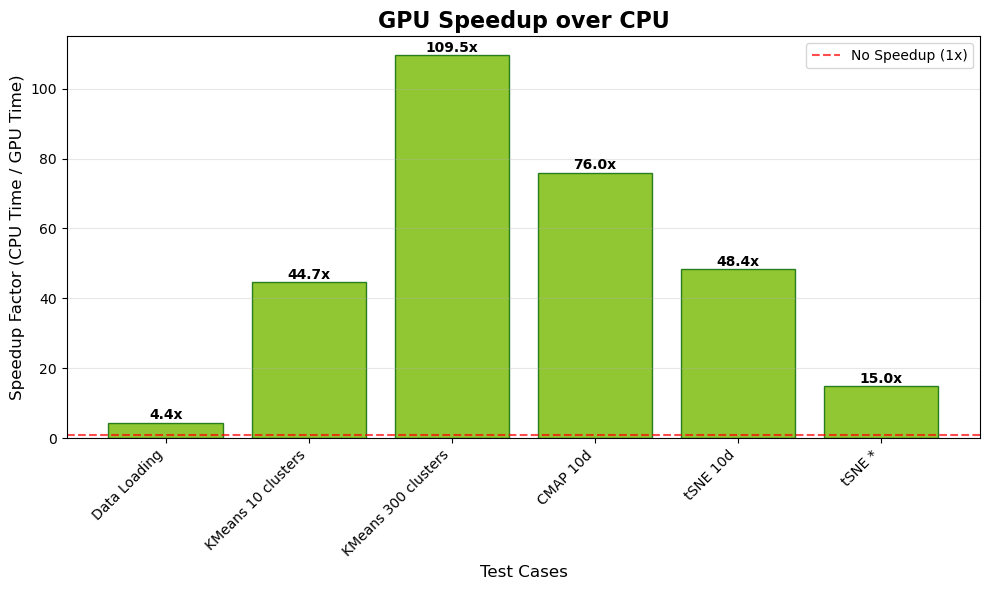

Speedup Summary:
Data Loading: CPU=6.9s, GPU=1.6s, Speedup=4.4x
KMeans 10 clusters: CPU=48.7s, GPU=1.1s, Speedup=44.7x
KMeans 300 clusters: CPU=1314.0s, GPU=12.0s, Speedup=109.5x
CMAP 10d: CPU=2173.2s, GPU=28.6s, Speedup=76.0x
tSNE 10d: CPU=2154.0s, GPU=44.5s, Speedup=48.4x
tSNE *: CPU=2154.0s, GPU=144.0s, Speedup=15.0x


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Insert your times here (in seconds)
cpu_times = [6.9, 48.7, 21.9*60, 36.22*60, 35.9*60, 35.9*60]  # Replace with your CPU times
gpu_times = [1.56, 1.09, 12, 28.6, 44.5, 2.4*60]      # Replace with your GPU times

# Calculate speedup (CPU time / GPU time)
speedup = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]

# Custom labels for your test cases
test_cases = ['Data Loading', 'KMeans 10 clusters', 'KMeans 300 clusters','CMAP 10d', 'tSNE 10d', 'tSNE *']

# NVIDIA green color 
nvidia_green = '#76B900'    

# Choose your preferred darker color
bar_color = nvidia_green  # Change to forest_green for even darker

# Create the speedup plot
plt.figure(figsize=(10, 6))
bars = plt.bar(test_cases, speedup, color=bar_color, edgecolor='darkgreen', alpha=0.8)

# Add value labels on top of bars
for i, (bar, speed) in enumerate(zip(bars, speedup)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{speed:.1f}x', ha='center', va='bottom', fontweight='bold')

plt.title('GPU Speedup over CPU', fontsize=16, fontweight='bold')
plt.ylabel('Speedup Factor (CPU Time / GPU Time)', fontsize=12)
plt.xlabel('Test Cases', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Rotate x-axis labels if they're long
plt.xticks(rotation=45, ha='right')

# Add a horizontal line at 1x (no speedup)
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No Speedup (1x)')
plt.legend()

plt.tight_layout()
plt.show()

# Print speedup summary with custom labels
print("Speedup Summary:")
for i, (label, cpu, gpu, speed) in enumerate(zip(test_cases, cpu_times, gpu_times, speedup)):
    print(f"{label}: CPU={cpu:.1f}s, GPU={gpu:.1f}s, Speedup={speed:.1f}x")
